In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [2]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import pandas as pd

# Load environment variables from .env file
from dotenv import load_dotenv
load_dotenv(dotenv_path='./credvar.env')


# Get the database credentials from environment variables
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_host = os.getenv('DB_HOST')
db_port = os.getenv('DB_PORT')
db_name = os.getenv('DB_NAME')

# Create the database URL
db_url = f'postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}'

# Create the SQLAlchemy engine
engine = create_engine(db_url)

# Query the database and load data into a DataFrame
query = 'SELECT * FROM loan_data'
loan_data = pd.read_sql(query, engine)

# Display the DataFrame
loan_data.head()


,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_duration,percent_of_income,years_at_residence,age,other_credit,housing,existing_loans_count,job,dependents,phone,cus_default
0,< 0 DM,6,critical,furniture/appliances,1169.0,unknown,> 7 years,4,4,67,none,own,2,skilled,1,True,False
1,1 - 200 DM,48,good,furniture/appliances,5951.0,< 100 DM,1 - 4 years,2,2,22,none,own,1,skilled,1,False,True
2,unknown,12,critical,education,2096.0,< 100 DM,4 - 7 years,2,3,49,none,own,1,unskilled,2,False,False
3,< 0 DM,42,good,furniture/appliances,7882.0,< 100 DM,4 - 7 years,2,4,45,none,other,1,skilled,2,False,False
4,< 0 DM,24,poor,car,4870.0,< 100 DM,1 - 4 years,3,4,53,none,other,2,skilled,2,False,True


# Determining patterns in data
Pulling correlation values of features against likelihood of customer default

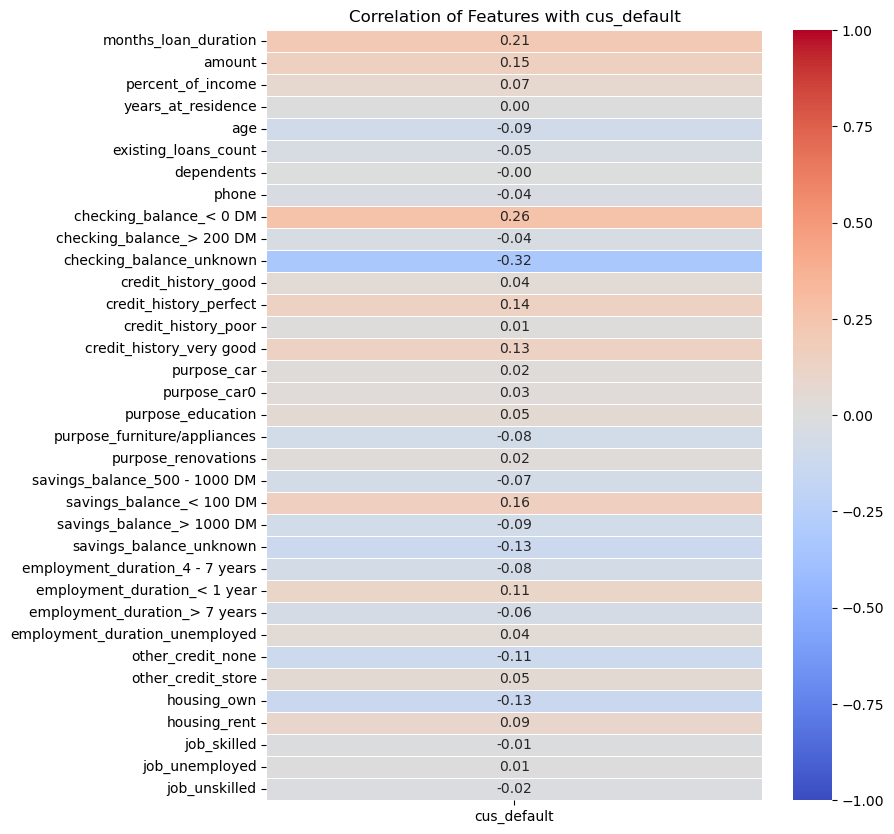

In [4]:
# Encode categorical variables using One-Hot Encoding
loan_data_encoded = pd.get_dummies(loan_data, drop_first=True)

# Compute the correlation matrix
corr_matrix = loan_data_encoded.corr()

# Filter the correlations for cus_default
cus_default_corr = corr_matrix[['cus_default']].drop(index='cus_default')

# Plot the heatmap
plt.figure(figsize=(8, 10))
sns.heatmap(cus_default_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Correlation of Features with cus_default')
plt.show()


Filter and sort the data to show ranking of impact on default plausibility

In [5]:
# Create a boolean mask for correlations with an absolute value >= 0.5
filter = cus_default_corr.abs() >= 0.1

# Filter the correlation matrix using the mask
high_corr_features = corr_matrix[filter].stack().reset_index()
high_corr_features.columns = ['Feature1', 'Feature2', 'Correlation']
high_corr_features = high_corr_features[high_corr_features['Feature1'] != high_corr_features['Feature2']]

# Sort the DataFrame by the Correlation column
high_corr_features_sorted = high_corr_features.sort_values(by='Correlation', ascending=False)

# Print the sorted features with high correlation
print(high_corr_features_sorted)

                        Feature1     Feature2  Correlation
2        checking_balance_< 0 DM  cus_default     0.258333
0           months_loan_duration  cus_default     0.214927
6       savings_balance_< 100 DM  cus_default     0.161007
1                         amount  cus_default     0.154739
4         credit_history_perfect  cus_default     0.144767
5       credit_history_very good  cus_default     0.134448
8   employment_duration_< 1 year  cus_default     0.106397
9              other_credit_none  cus_default    -0.113285
7        savings_balance_unknown  cus_default    -0.129238
10                   housing_own  cus_default    -0.134589
3       checking_balance_unknown  cus_default    -0.322436


As seen above, there are 7 features that have a positive correlation with likelihood to default and four features with a negative correlation. 

Listed below are the correlations in more understandable terms:
* Negative checking balance
* Longer loan durations
* Savings balance below 100 marks
* The total loan amount
* Perfect credit history
* Very good credit history
* Employment duration under 1 year
* No other lines of credit
* Unknown savings balance
* Housing is owned
* Checking balance is unknown

# Model Prediction

### Separate Categorical and Numerical Features

In [8]:
# Extract numerical features and store them in X_num
X_num = loan_data[['months_loan_duration', 'amount', 'percent_of_income', 'years_at_residence', 'age', 
            'existing_loans_count', 'dependents']].values

# Extract categorical features and store them in X_cat
X_cat = loan_data[['checking_balance', 'credit_history', 'purpose', 'savings_balance', 'employment_duration', 'other_credit', 'housing',
                 'job', 'phone']].values

# Extract the target variable and store it in y
y = loan_data['cus_default'].values

# Print the shapes of the numerical, categorical, and target arrays
print(f'{"Numerical Feature Array Shape: ":<35} {X_num.shape}')
print(f'{"Categorical Feature Array Shape: ":<35} {X_cat.shape}')
print(f'{"Label Array Shape: ":<35} {y.shape}')

Numerical Feature Array Shape:      (1000, 7)
Categorical Feature Array Shape:    (1000, 9)
Label Array Shape:                  (1000,)


### Encoding Categorical Variables with One-Hot Encoding

In [10]:
# Initialize and fit a OneHotEncoder on the categorical features
encoder = OneHotEncoder(sparse_output=False)
encoder.fit(X_cat)

# Transform the categorical features using the fitted encoder
X_enc = encoder.transform(X_cat)

# Print the shape of the encoded feature array
print(f'Encoded Feature Array Shape: {X_enc.shape}')

Encoded Feature Array Shape: (1000, 37)


### Combine all features

In [12]:
# Combine numerical and encoded categorical features into one feature array
X = np.hstack((X_num, X_enc))

# Print the shape of the combined feature array
print(f'Feature Array Shape: {X.shape}')

Feature Array Shape: (1000, 44)


This results in 44 columns and 1000 rows of data. 

### Split data into training, validation, and test sets

In [17]:
# Split the data into training and hold-out sets with stratified sampling
X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# Further split the hold-out set into validation and test sets
X_valid, X_test, y_valid, y_test = train_test_split(X_hold, y_hold, test_size=0.5, random_state=1, stratify=y_hold)

# Print the shapes of the training, validation, and test feature arrays to verify correct split
print(f'{"Training Features Shape: ":<30} {X_train.shape}')
print(f'{"Validation Features Shape: ":<30} {X_valid.shape}')
print(f'{"Test Features Shape: ":<30} {X_test.shape}')

Training Features Shape:       (700, 44)
Validation Features Shape:     (150, 44)
Test Features Shape:           (150, 44)


First train_test_split pulls 30% for testing data, second splits that in half for validation. 

### Testing Logistic Regression model

In [20]:
# Initialize a Logistic Regression model
lr_mod = LogisticRegression(solver='lbfgs', max_iter=10000, multi_class='multinomial', penalty=None)
# Enact cross-validation for higher accuracy
cv_scores = cross_val_score(lr_mod, X_train, y_train, cv=5, scoring='accuracy')

print(f'Logistic Regression CV Accuracy Scores: {cv_scores}')
print(f'Logistic Regression Mean CV Accuracy: {cv_scores.mean():.2f}')


Logistic Regression CV Accuracy Scores: [0.72857143 0.75       0.73571429 0.75       0.70714286]
Logistic Regression Mean CV Accuracy: 0.73


In [21]:
lr_mod.fit(X_train, y_train)

# Print the training and validation accuracy of the Logistic Regression model
print(f'{"Training Accuracy: ":<30} {round(lr_mod.score(X_train, y_train), 4)}')
print(f'{"Validation Accuracy: ":<30} {round(lr_mod.score(X_valid, y_valid), 4)}')

Training Accuracy:             0.7671
Validation Accuracy:           0.74


Not great, but I have definitely seen regression do worse on other datasets

### Testing Decision Tree model for max depth

In [24]:
# Initialize lists to store training and validation accuracy for Decision Trees
dt_train_acc = []
dt_valid_acc = []
depth_range = range(2,30)

# Loop through the depth range and train a Decision Tree for each depth
for d in depth_range:
    temp_tree = DecisionTreeClassifier(max_depth=d, random_state=1)
    temp_tree.fit(X_train, y_train)
    dt_train_acc.append(temp_tree.score(X_train, y_train))
    dt_valid_acc.append(temp_tree.score(X_valid, y_valid))

# Find the optimal max_depth based on validation accuracy
dt_idx = np.argmax(dt_valid_acc)
dt_opt_depth = depth_range[dt_idx]

# Print the optimal max_depth and corresponding training and validation accuracy
print(f'{"Optimal value for max_depth: ":<40} {dt_opt_depth}')
print(f'{"Training Accuracy for Optimal Model: ":<40} {round(dt_train_acc[dt_idx], 4)}')
print(f'{"Validation Accuracy for Optimal Model: ":<40} {round(dt_valid_acc[dt_idx], 4)}')

Optimal value for max_depth:             6
Training Accuracy for Optimal Model:     0.8386
Validation Accuracy for Optimal Model:   0.7267


Better training accuracy, but lower validation score; model may be slightly overfitting. 

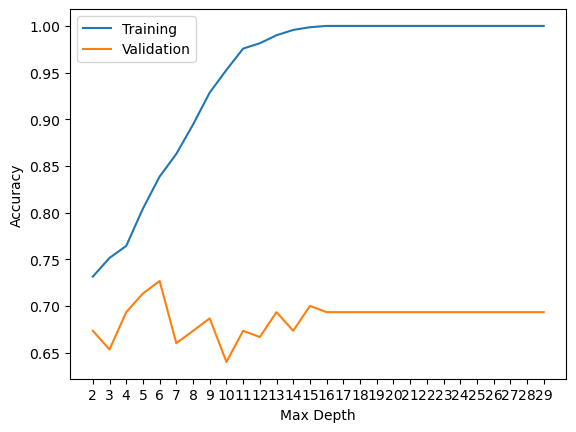

In [26]:
# Plot training and validation accuracy as a function of max_depth
plt.plot(depth_range, dt_train_acc, label='Training')
plt.plot(depth_range, dt_valid_acc, label='Validation')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.xticks(depth_range)
plt.legend()
plt.show()

Not likely an ideal model for this data. 

### Testing Random Forest model

In [29]:
# Initialize lists to store training and validation accuracy for Random Forests
rf_train_acc = []
rf_valid_acc = []

# Loop through the depth range and train a Random Forest for each depth
for d in depth_range:
    temp_forest = RandomForestClassifier(n_estimators=100, max_depth=d, random_state=1)
    temp_forest.fit(X_train, y_train)
    rf_train_acc.append(temp_forest.score(X_train, y_train))
    rf_valid_acc.append(temp_forest.score(X_valid, y_valid))

# Find the optimal max_depth based on validation accuracy for Random Forests
rf_idx = np.argmax(rf_valid_acc)
rf_opt_depth = depth_range[rf_idx]

# Print the optimal max_depth and corresponding training and validation accuracy for Random Forests
print(f'{"Optimal value for max_depth: ":<40} {rf_opt_depth}')
print(f'{"Training Accuracy for Optimal Model: ":<40} {round(rf_train_acc[rf_idx], 4)}')
print(f'{"Validation Accuracy for Optimal Model: ":<40} {round(rf_valid_acc[rf_idx], 4)}')

Optimal value for max_depth:             13
Training Accuracy for Optimal Model:     0.9986
Validation Accuracy for Optimal Model:   0.76


Plotting depth for visualization

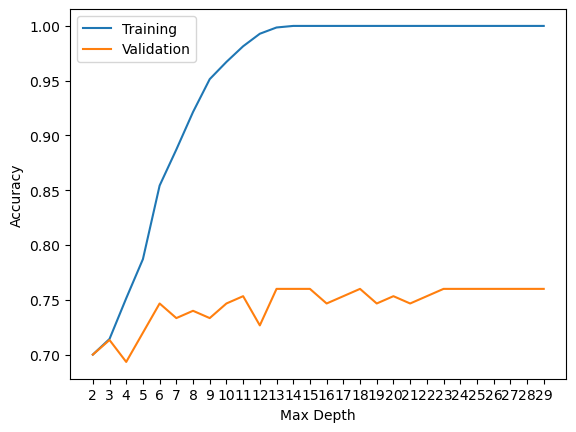

In [31]:
# Plot training and validation accuracy as a function of max_depth for Random Forests
plt.plot(depth_range, rf_train_acc, label='Training')
plt.plot(depth_range, rf_valid_acc, label='Validation')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.xticks(depth_range)
plt.legend()
plt.show()

In [32]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest classifier
rf = RandomForestClassifier(random_state=1)

# Perform Grid Search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters and best accuracy
print(f'Best Hyperparameters: {grid_search.best_params_}')
print(f'Best Cross-Validation Accuracy: {grid_search.best_score_:.2f}')


Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validation Accuracy: 0.77


Model becomes overfitted extremely quickly with this data, but depth of 13 yields the highest validation accuracy thus far. 

In [34]:
# Using the best hyperparameters from Grid Search
final_model = RandomForestClassifier(n_estimators=100, max_depth=13, min_samples_leaf=1, min_samples_split=2, random_state=1)

final_model.fit(X_train, y_train)

# Print the training, validation, and test accuracy for the final model
print(f'{"Training Accuracy for Final Model: ":<40} {round(final_model.score(X_train, y_train), 4)}')
print(f'{"Validation Accuracy for Final Model: ":<40} {round(final_model.score(X_valid, y_valid), 4)}')
print(f'{"Testing Accuracy for Final Model: ":<40} {round(final_model.score(X_test, y_test), 4)}')

Training Accuracy for Final Model:       0.9986
Validation Accuracy for Final Model:     0.76
Testing Accuracy for Final Model:        0.74


Testing accuracy still higher than Logistic Regression at Testing Phase. 

In [36]:
# Predict the test set labels using the final model
test_pred = final_model.predict(X_test)

# Create a confusion matrix from the test predictions
matrix = confusion_matrix(y_test, test_pred)

# Convert the confusion matrix to a DataFrame for better readability
matrix_df = pd.DataFrame(matrix, index=['No', 'Yes'], columns=['No', 'Yes'])

# Display the confusion matrix
matrix_df

,No,Yes
No,94,11
Yes,28,17


94 (Top-left): The model correctly predicted no when the actual value was no.

11 (Top-right): The model incorrectly predicted yes when the actual value was no.

28 (Bottom-left): The model incorrectly predicted no when the actual value was yes.

17 (Bottom-right): The model correctly predicted yes when the actual value was yes.

False Negatives are going to be the biggest concern here. 
28 misidentified defaulted loans is high in comparison to other values. 

### Testing KNeighbors with cosine similarity model

Optimal number of neighbors:   4
Training Accuracy for Optimal Model:  0.7814
Validation Accuracy for Optimal Model:  0.78


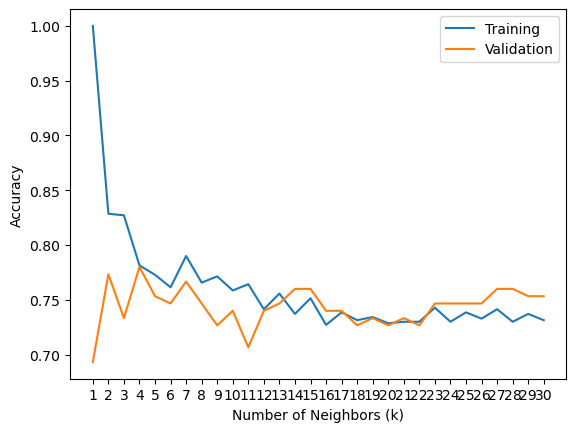

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

# Compute cosine similarity matrix
cosine_sim = cosine_similarity(X_train_scaled, X_train_scaled)

# Define the range of k values to test
k_range = range(1, 31)

# Initialize lists to store training and validation accuracy
knn_train_acc = []
knn_valid_acc = []

# Loop through the range of k values and evaluate KNN for each k
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, metric='cosine')
    knn.fit(X_train_scaled, y_train)
    
    # Calculate training and validation accuracy
    knn_train_acc.append(knn.score(X_train_scaled, y_train))
    knn_valid_acc.append(knn.score(X_valid_scaled, y_valid))

# Find the optimal number of neighbors based on validation accuracy
knn_opt_k = k_range[np.argmax(knn_valid_acc)]

# Print the optimal number of neighbors and corresponding accuracies
print(f'{"Optimal number of neighbors: ":<30} {knn_opt_k}')
print(f'{"Training Accuracy for Optimal Model: ":<30} {round(knn_train_acc[np.argmax(knn_valid_acc)], 4)}')
print(f'{"Validation Accuracy for Optimal Model: ":<30} {round(knn_valid_acc[np.argmax(knn_valid_acc)], 4)}')

# Plot training and validation accuracy as a function of k
plt.plot(k_range, knn_train_acc, label='Training')
plt.plot(k_range, knn_valid_acc, label='Validation')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.xticks(k_range)
plt.legend()
plt.show()

In [40]:
#set optimal K Nearest Neighbor model based on optimal neighbors value
opt_knn = KNeighborsClassifier(n_neighbors=4, metric='cosine')

#fit the model
opt_knn.fit(X_train_scaled, y_train)

#print the test score. 
print("KNN Model Testing Accuracy:", opt_knn.score(X_test_scaled, y_test))

KNN Model Testing Accuracy: 0.72


Even though validation scores were higher than Random Forest, test accuracy comes out lower. 

Proceeding with predictions to determine where it may fall short. 

In [42]:
# Predict the test set labels using the final model
test_pred_K = opt_knn.predict(X_test_scaled)

# Create a confusion matrix from the test predictions
matrix_K = confusion_matrix(y_test, test_pred_K)

# Convert the confusion matrix to a DataFrame for better readability
matrix_K = pd.DataFrame(matrix_K, index=['No', 'Yes'], columns=['No', 'Yes'])

# Display the confusion matrix
matrix_K

,No,Yes
No,95,10
Yes,32,13


K model in its current state is definitely a larger risk than random forest. 